C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="is_male <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]", fillcolor="#e5813960"] ;
1 [label="pclass_3 <= 0.5\ngini = 0.383\nsamples = 314\nvalue = [81, 233]", fillcolor="#399de5a6"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.1\nsamples = 170\nvalue = [9, 161]", fillcolor="#399de5f1"] ;
1 -> 2 ;
3 [label="gini = 0.5\nsamples = 144\nvalue = [72, 72]", fillcolor="#e5813900"] ;
1 -> 3 ;
4 [label="age <= 6.5\ngini = 0.306\nsamples = 577\nvalue = [468, 109]", fillcolor="#e58139c4"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="gini = 0.444\nsamples = 24\nvalue = [8, 16]", fillcolor="#399de57f"] ;
4 -> 5 ;
6 [label="gini = 0.28\nsamples = 553\nvalue = [460, 93]", fillcolor="#e58139cb"] ;
4 -> 6 ;
}


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


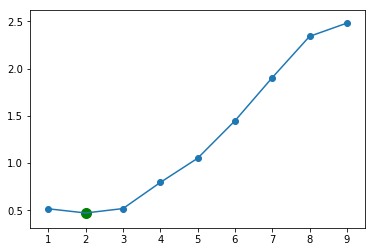

In [27]:
import os
import random
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
from matplotlib import pyplot as plt
from sklearn.tree import export_graphviz


def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))


#посмотрим на большее число колонок
pd.set_option('display.expand_frame_repr', False)
data_train = pd.read_csv('train_titanic.csv')
data_test = pd.read_csv('test_titanic.csv')
data_submission = pd.read_csv('gender_submission.csv')

data_train['is_test'] = False
data_test['is_test'] = True
data = pd.concat([data_train, data_test], axis=0)

data.columns = data.columns.str.lower()

#проверим содержит ли имя Mr, Mrs, Miss
data['is_mr'] = data['name'].str.lower().str.contains('|'.join(['mr.', 'mrs.', 'miss.'])).astype(int)
data['is_male'] = data['sex'].str.match('male').astype(int)
data.age.fillna(data.age.median(), inplace=True)

#создаем датафрейм с колонками: возраст, is_mr, is_male, pclass
X = pd.DataFrame({'age': data['age'], 'is_mr': data['is_mr'], 'is_male': data['is_male'], 'pclass': data['pclass'], 'is_test': data['is_test']})

#создаем три колонки вместо pclass
X = pd.get_dummies(X, columns=['pclass'])

y = data_train['Survived']

X_train = X[~X.is_test]
X_test = X[X.is_test]

del X_train['is_test']
del X_test['is_test']

depths = np.arange(1, 10)
grid = {'max_depth': depths}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='neg_log_loss', cv=5)
gridsearch.fit(X_train, y)

scores = [-x.mean_validation_score for x in gridsearch.grid_scores_]
plt.plot(depths, scores)
plt.scatter(depths, scores)
best_point = np.argmin(scores)
plt.scatter(depths[best_point], scores[best_point], c='g', s=100)

clf_final = DecisionTreeClassifier(max_depth=depths[best_point])
clf_final.fit(X_train, y)

y_pred_proba = clf_final.predict_proba(X_test)
y_pred = clf_final.predict(X_test)

submit = pd.DataFrame(y_pred, columns=data_submission.columns[1:])
submit['ID'] = data_submission.PassengerId
submit = submit[[submit.columns[-1]]+list(submit.columns[:-1])]
submit.to_csv('submit_titanic.csv', index=False)

get_tree_dot_view(clf_final, list(X_train.columns))

